In [20]:
import os
import time
import uuid #Give unique names to each object
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # OpenCV reads the image in BGR format

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') # uuid1ame function generates a unique name for each image
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
!labelme

2024-06-12 14:22:45,046 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Isara Liyanage\.labelmerc


### Review Dataset and Build Image Loading Function

In [3]:
import tensorflow as tf
import json # Labels are in jason format
import numpy as np
from matplotlib import pyplot as plt

#### Standard code to limit the gpu usage

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [52]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [53]:
images.as_numpy_iterator().next() # Checking whether the images are loaded correctly

b'data\\images\\145ea9ce-2435-11ef-9b1e-be9ffffbf19a.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [55]:
images = images.map(load_image)

In [45]:
images.as_numpy_iterator().next()

array([[[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 122],
        [116, 110, 122]],

       [[173, 178, 172],
        [172, 177, 171],
        [173, 175, 170],
        ...,
        [116, 111, 118],
        [116, 110, 120],
        [116, 110, 120]],

       [[175, 178, 171],
        [174, 177, 170],
        [174, 175, 169],
        ...,
        [117, 112, 119],
        [117, 112, 119],
        [116, 111, 118]],

       ...,

       [[164, 164, 166],
        [164, 164, 166],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [137, 138, 133],
        [137, 138, 133]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [137, 138, 133],
        [136, 137, 132],
        [136, 137, 132]],

       [[163, 163, 165],
        [163, 163, 165],
        [164, 164, 166],
        ...,
        [136, 137, 132],
        [136, 137, 132],
        [136, 137, 132]]

In [56]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### View Raw Images

In [57]:
image_generator = images.batch(4).as_numpy_iterator()



In [60]:
plot_images = image_generator.next()

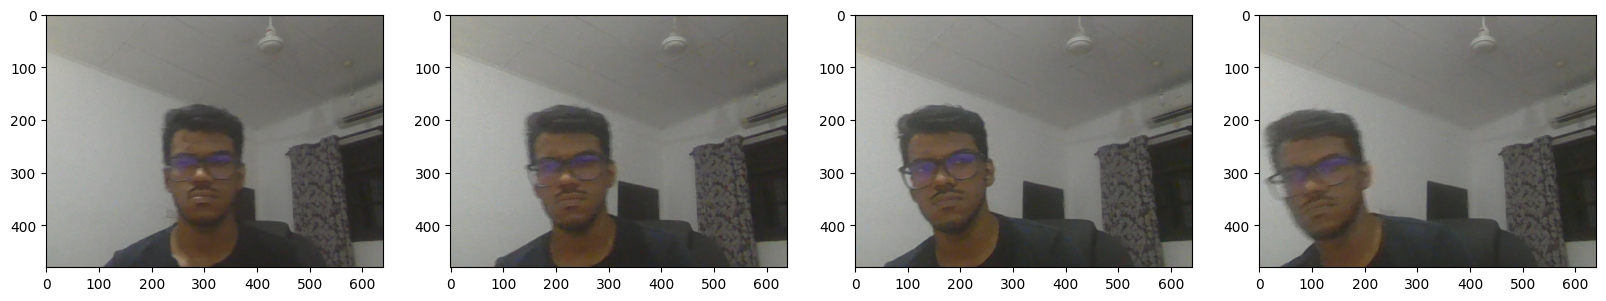

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### Split the data


In [66]:
import os
import shutil
import random

# Paths
input_dir = 'data/images'
#output_dir = 'output'
train_dir = os.path.join('data/train', 'images')
val_dir = os.path.join('data/val', 'images')
test_dir = os.path.join('data/test', 'images')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

# Shuffle the image files
random.seed(1337)
random.shuffle(image_files)

# Calculate split indices
total_images = len(image_files)
train_split = int(0.7 * total_images)
val_split = int(0.85 * total_images)  # 0.7 + 0.15 = 0.85

# Split the images
train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Move images to respective directories
for file in train_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(train_dir, file))

for file in val_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(val_dir, file))

for file in test_files:
    shutil.move(os.path.join(input_dir, file), os.path.join(test_dir, file))

print(f'Total images: {total_images}')
print(f'Training images: {len(train_files)}')
print(f'Validation images: {len(val_files)}')
print(f'Testing images: {len(test_files)}')


Total images: 90
Training images: 62
Validation images: 14
Testing images: 14


### Moving the labels

In [67]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

### Image Augmentation

In [5]:
cv2.imread(os.path.join('data','train','images','1a3de05a-2435-11ef-8789-be9ffffbf19a.jpg')).shape

(480, 640, 3)

In [6]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load Data

In [15]:
img = cv2.imread(os.path.join('data','train', 'images','17255597-2435-11ef-86ed-be9ffffbf19a.jpg'))

In [18]:
with open(os.path.join('data', 'train', 'labels', '17255597-2435-11ef-86ed-be9ffffbf19a.json'), 'r') as f:
    label = json.load(f)

In [19]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[79.88372093023253, 147.2674418604651],
    [265.3488372093023, 398.4302325581395]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\17255597-2435-11ef-86ed-be9ffffbf19a.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnL

In [20]:
# Extract Coordinates and Rescale to Match Image Resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1] # Coords are in format [x1, y1, x2, y2]

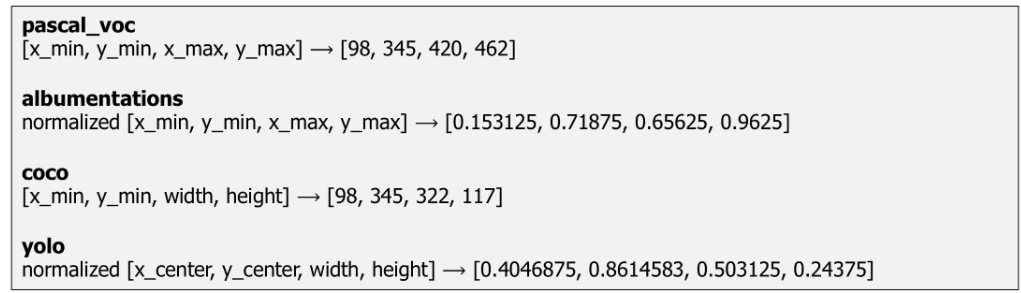

##### Usually we use pascal_voc. But since we are augmenting the images we have to standardize the bounding box. So we use 'albumentations' method

In [21]:
coords = list(np.divide(coords, [640,480,640,480])) # Original image resolution is 640x480

In [22]:
coords

[0.12481831395348833,
 0.3068071705426357,
 0.41460755813953487,
 0.8300629844961239]

In [24]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

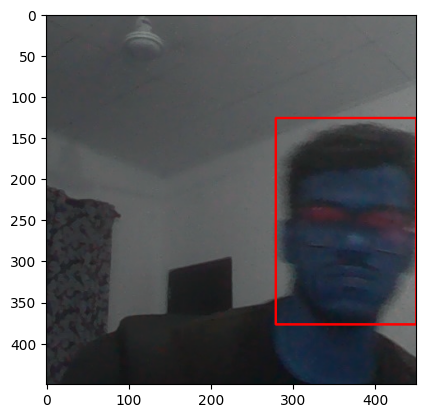

In [25]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), # Normalized values are multiplied by new resolutions
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Augmentation Pipeline

In [9]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [12]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

### Prepare Labels

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [14]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### Combine Images and Labels

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 840, 840)

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

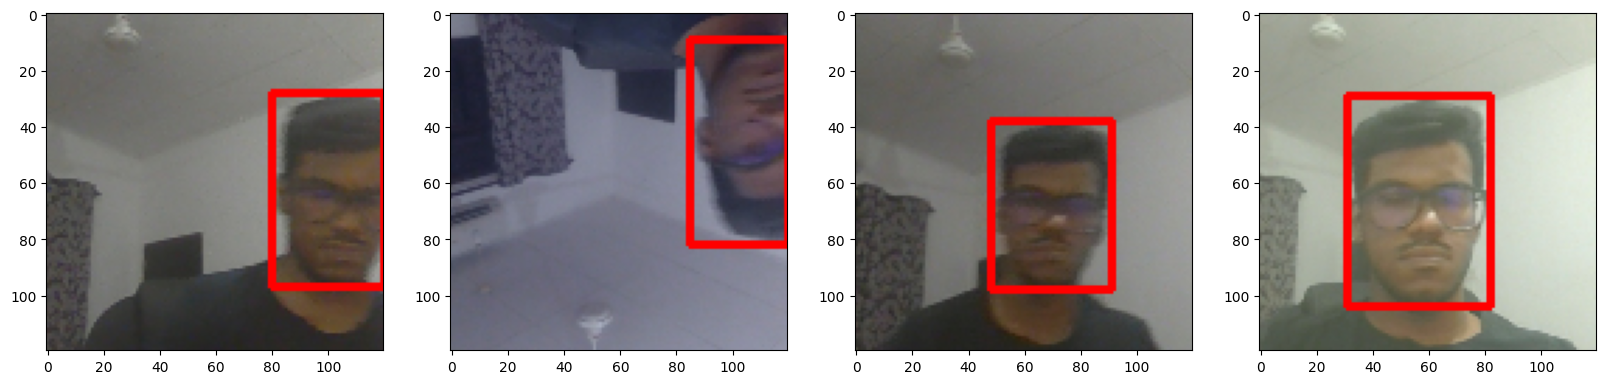

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)